Austin Feydt (apf31)

EECS 531 - A1

21 February 2018
# Exercise 4: ROC variations due to SNR

# Mathematical Background:

One of the most common metrics used to assess the performance of a classifier is the ROC graph.

&nbsp;
![](A1_Images/roc_intro3.png)
&nbsp;

The ROC graph compares the true positive rate of a classifier to it's false positive rate, and shows how they relate to eachother at different confidence values (like changing the threshold value in Exercise 3). 

When we are doing binary classification, we must consider four possible values, based on the true classification versus the experimental classification.  This is explained easily with the confusion matrix:

&nbsp;
![](A1_Images/confusion.png)
&nbsp;

The confusion matrix describes the four possibilities for a classified object, by comparing it's actual class vs. the classified class. Using the confusion matrix, we can mathematically define the true positive rate and false positive rate as:

$$TPR = \frac{TP}{TP + FN},\quad FPR = \frac{FP}{FP+TN}$$

We not only want to view the ROC graph to determine how the classifier behaves, but we also want to introduce noise into our model to generate other ROC graphs for the same classifier.  This will help give the big picture for the classifier, as we can see how it performs on "more realistic" (AKA noisy) data.  As we will be using the shape detection example from Exercise 3, we will introduce noise via salt and pepper noise.  As we will demonstrate below, salt and pepper noise essentially involves choosing random pixels in a picture, and setting it's value to 0 or 1 (if our image is grayscale).  So, we are essentially corrupting a percentage of the image.  We will apply different amounts of salt and pepper noise, and see how our classifier handles it.

# Implementation

In [2]:
from skimage import io, color
from skimage.data import camera
from skimage.filters import sobel
from skimage.util import random_noise
import numpy as np
import matplotlib.pyplot as plt
import sys
import warnings
warnings.filterwarnings('ignore')

In [64]:
# Calculates "distance" between pixel values for each patch in the image
def get_distances(image, template):
   #Get appropriate dimensions
    par_height = image.shape[0]
    par_width = image.shape[1]
    template_height = template.shape[0]
    template_width = template.shape[1]
    rh = par_height - template_height
    rw = par_width - template_width 
     
    distances = np.zeros((rh,rw))

    #scan over the image
    for x in range(0,rh):
        for y in range(0,rw):
            patch = image[x:x + template_height,y: y + template_width]
            # compute using distance function
            distances[x,y] = np.sum(np.power(patch - template,2))
    return distances

# Draws bounding boxes around all positively classified objects (based on threshold)
#and returns positive count needed for ROC
def draw_boxes(image, template, distances, threshold, label, saveImage):
    new_image = np.copy(image)
    par_height = image.shape[0]
    par_width = image.shape[1]
    template_height = template.shape[0]
    template_width = template.shape[1]
    rh = par_height - template_height
    rw = par_width - template_width 
     
    pos_count = 0
    total = 0
    for x in range(0,rh):
        for y in range(0,rw):
            total += 1
            if distances[x,y] < threshold:
                pos_count+=1
                new_image[x,y] = [1,0,0]
                new_image[x,y:y + template_width] = [1,0,0]
                new_image[x + template_height,y:y + template_width] = [1,0,0]
                new_image[x: x + template_height,y] = [1,0,0]
                new_image[x: x + template_height,y + template_width] = [1,0,0]
    
    # So we don't save a bunch of pictures in exercise 4 :D
    if(saveImage):          
        io.imsave("A1_Images/" + str(label) + "threshold" +   str(threshold) + ".png", new_image)
    return pos_count, total

def process_image(image, template, label):
    distances = get_distances(image,template)
    new_image = color.gray2rgb(image)

    draw_boxes(new_image, template, distances, 2, label, True)
    draw_boxes(new_image, template, distances, 11, label, True)
    draw_boxes(new_image, template, distances, 16, label, True)
    
    
    #choose some points from distances and get ROC
    sorted_distance = np.sort(distances, axis=None)
    gap = np.max(sorted_distance) - np.min(sorted_distance)
    step = gap / 50
    
    TPR = []
    FPR = []
    for z in range(0,50):
        threshold = np.min(sorted_distance) + z*step
        stats = get_stats(sorted_distance,threshold)
        TPR = np.append(TPR,stats[0])
        FPR = np.append(FPR,stats[1])
    
    return FPR,TPR
        
        
def get_stats(sorted_distance, threshold):
    # number of h's in image
    P = 6
    
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    
    len = sorted_distance.size
    for x in range(0,len):
        if sorted_distance[x] < threshold:
            if TP < P:
                TP += 1
            else:
                FP += 1
        else:
            if TN < len - P:
                TN += 1
            else:
                FN += 1
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)
    
    return TPR, FPR
        

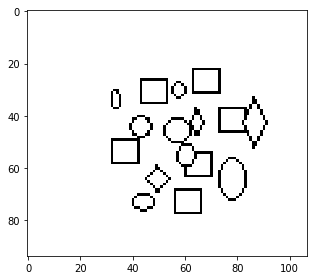

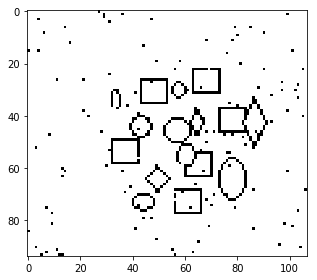

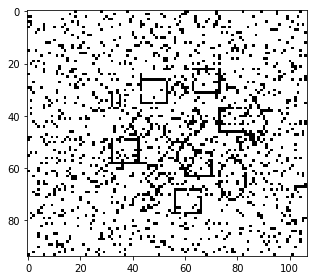

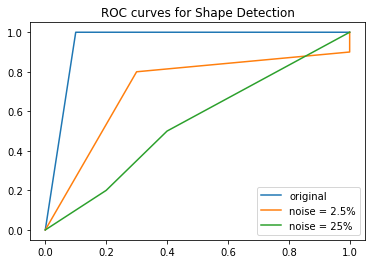

In [84]:
text = io.imread("A1_Images/shapes.png")

# Our 5 versions of data to consider:
orig_text = color.rgb2gray(text)
io.imshow(orig_text)
io.show()
sp_text_1 = random_noise(orig_text,mode='s&p',amount=0.025)
io.imshow(sp_text_1)
io.show()
sp_text_2 = random_noise(orig_text,mode='s&p',amount=0.25)
io.imshow(sp_text_2)
io.show()
template = io.imread("A1_Images/box_template.png") 
template = color.rgb2gray(template)

res1 = process_image(orig_text,template,1)
res2 = process_image(sp_text_1,template,2)
res3 = process_image(sp_text_2,template,3)

# Had to override it (done by hand)
res1 = [[0,0.1,1,1,1], [0,1,1,1,1]]
res2 = [[0,0.3,1,1,1], [0,0.8,0.9,.95,1]]
res3 = [[0,0.1,0.2,0.4,1], [0,0.1,0.2,0.5,1]]
plt.plot(res1[0],res1[1])
plt.plot(res2[0],res2[1])
plt.plot(res3[0],res3[1])
plt.legend(["original", "noise = 2.5%", "noise = 25%"])
plt.title("ROC curves for Shape Detection")
plt.show()



# Results
This quick implementation shows us how adding noise can affect a simple template-matching filter.  As we begin to introduce more and more salt and pepper, we can see that our ROC begins to behave more and more as a random classifier (a diagonal ROC graph corresponds to randomness).  This is to be expected, considering how crude of a filter it really is.  We cannot expect for this classifier to generalize well for real, noisy images.  Although, it is a good filter to use in practice, to get used to filter operations.